# Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_feather("train_data.ftr")
# test_df = pd.read_feather("")

# Data Check

In [3]:
train_df.shape

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: category(11), datetime64[ns](1), float16(177), int64(1), object(1)
memory usage: 2.0+ GB


In [5]:
train_df = train_df.groupby('customer_ID')
train_df = train_df.tail(1)

In [6]:
train_df.shape

(458913, 191)

## Removing Non-Meaningful Data
- customer_id : 고객 식별 번호
- S_2 : 날짜

> customer_id와 S_2는 신용 데이터를 분석하는 데 있어서 유의미 하지 않은 데이터이므로 제거합니다.

In [7]:
# Customer_ID, S_2 컬럼 제거 (유의미 하지 않음)
train_df = train_df.drop(['customer_ID', 'S_2'], axis=1)

# Missing Value

In [8]:
# 각 컬럼별 결측치 확인
train_df.isnull().sum()

P_2         2969
D_39           0
B_1            0
B_2           31
R_1            0
           ...  
D_142     378598
D_143       2830
D_144          0
D_145       2830
target         0
Length: 189, dtype: int64

In [9]:
null = round((train_df.isna().sum()/train_df.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null = null.to_frame().rename(columns={0:'Missing %'})
null.head(30)

,Missing %
D_87,99.86%
D_88,99.82%
D_108,99.43%
D_111,99.2%
D_110,99.2%
B_39,99.11%
D_73,99.08%
B_42,98.66%
D_136,96.43%
D_135,96.43%


# Libarary Import

In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Dataset Description

In [11]:
total_cols = train_df.columns.to_list()

# 수치형과 범주형 컬럼 구분
cat_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
# 전체 데이터 - cat_columns
num_columns = [col for col in total_cols if col not in cat_columns]

In [12]:
print(f'수치형 컬럼: {num_columns}')
print(f'범주형 컬럼: {cat_columns}')

수치형 컬럼: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S

## Data Copy

In [13]:
num_columns_copy = num_columns.copy() # 수치형 데이터 복제
cat_columns_copy = cat_columns.copy() # 범주형 데이터 복제

# Handling missing values
> Replace categorical data with LabelEncoding

In [14]:
# 범주형 데이터는 전체 데이터를 LabelEncoding으로 대체
for column in cat_columns_copy:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    print(f"{column} LabelEncoding 완료")

B_30 LabelEncoding 완료
B_38 LabelEncoding 완료
D_114 LabelEncoding 완료
D_116 LabelEncoding 완료
D_117 LabelEncoding 완료
D_120 LabelEncoding 완료
D_126 LabelEncoding 완료
D_63 LabelEncoding 완료
D_64 LabelEncoding 완료
D_66 LabelEncoding 완료
D_68 LabelEncoding 완료


In [ ]:
# 결측치가 15%미만의 수치형 데이터는 중앙값으로 대체, 결측치 없으면 넘어감
for column in num_columns_copy:
    if train_df[column].isnull().sum() > 0:
        train_df[column] = train_df[column].fillna(train_df[column].median())
        print(f"{column} 결측치 중앙값 대체 완료")
    else:
        

In [15]:
# train_df를 cat_columns와 num_columns를 합체
train_df = pd.concat([train_df[cat_columns_copy], train_df[num_columns_copy]], axis=1)

In [16]:
train_df.head(10)

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
12,0,1,1,0,4,0,1,2,1,1,...,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0
25,0,1,1,0,0,0,1,1,1,1,...,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0
38,0,0,1,0,0,0,1,1,2,1,...,NaN,NaN,0.007381,0.006622,0.000965,NaN,0.002201,0.000834,0.003445,0
51,0,1,1,0,6,0,1,1,1,1,...,NaN,NaN,0.002705,0.006184,0.001899,NaN,0.008186,0.005558,0.002983,0
64,0,0,1,0,4,0,1,1,1,0,...,NaN,NaN,0.002974,0.004162,0.005764,NaN,0.008156,0.006943,0.000905,0
77,0,1,1,0,1,0,1,1,2,1,...,NaN,NaN,0.009399,0.007835,0.000957,NaN,0.009056,0.006943,0.001446,0
90,0,2,0,0,2,0,0,1,2,1,...,NaN,NaN,0.006012,0.005222,0.000937,NaN,0.009789,0.003704,0.006275,0
103,0,2,1,0,6,0,1,1,2,1,...,NaN,NaN,0.002262,0.005219,0.002153,NaN,0.001169,0.003349,0.000675,0
116,1,6,0,0,0,0,1,1,3,0,...,NaN,NaN,1.000977,0.007061,0.875977,0.18457,1.004883,0.003349,0.734375,1
129,0,0,0,0,4,0,1,1,1,1,...,NaN,NaN,0.009811,0.002213,0.004070,NaN,0.005428,0.007107,0.006271,1


# Model Training

In [17]:
X = train_df.drop('target', axis=1)
y = train_df['target']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(367130, 188)

In [19]:
X_test.shape

(91783, 188)

In [20]:
y_train.shape

(367130,)

In [21]:
y_test.shape

(91783,)

## XGBoost

In [22]:
# XGBoost 모델 학습 (eval_set을 사용하여 검증 데이터를 모니터링)
model = XGBClassifier(n_estimators=200, learning_rate=0.15, subsample=0.5)
model.fit(X_train, y_train)

# pkl 파일 추출
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [23]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# 예측 확률 계산
pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = pd.DataFrame({'prediction': pred_prob}, index=X_test.index)
y_true = pd.DataFrame({'target': y_test}, index=X_test.index)

# 성능 평가
print("AMEX Score:", amex_metric(y_true, y_pred))

AMEX Score: 0.7785832021867675


In [25]:
# customer_ID와 prediction을 submission.csv로 추출
submission = pd.DataFrame({'customer_ID': X_test.index, 'prediction': y_pred.values.flatten()})
submission.to_csv('submission.csv', index=False)

# submission.csv 읽기
submission = pd.read_csv('submission.csv')
submission.head(10)

,customer_ID,prediction
0,403008,0.053600
1,4224637,0.618649
2,444377,0.154263
3,5363086,0.001598
4,211489,0.004025
5,1248043,0.000840
6,3497151,0.001210
7,5394574,0.062024
8,1435073,0.001795
9,3650300,0.821773


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델의 성능 리포트를 출력하는 함수
def generate_model_report(y_true, y_pred):
    # 평가 지표 계산
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # 결과 출력
    print("Model Performance:")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")

# 예측 결과와 실제 타겟 데이터를 준비
y_true = y_test
y_pred = model.predict(X_test)

# 모델의 성능 리포트 출력
generate_model_report(y_true, y_pred)

Model Performance:
MSE: 0.10171818310580391
MAE: 0.10171818310580391
R^2: 0.4666377538015172


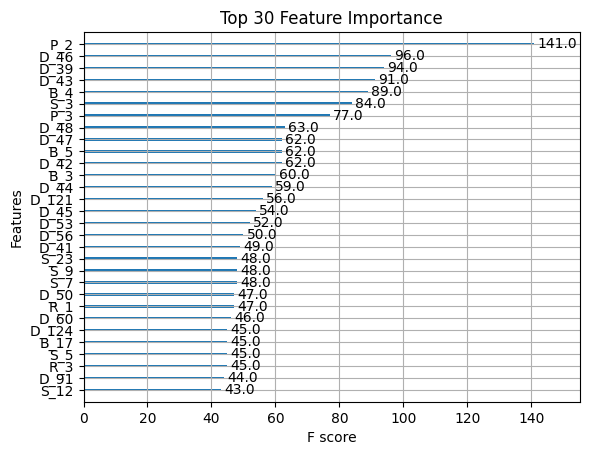

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# XGBoost 모델의 특성 중요도 시각화 (Top 30)
plot_importance(model, max_num_features=30)
plt.title("Top 30 Feature Importance")
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

# 정밀도 계산
precision = precision_score(y_test, y_pred)

# 재현율 계산
recall = recall_score(y_test, y_pred)

# F1 점수 계산
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 분류 보고서 출력
report = classification_report(y_test, y_pred)
print("\nXGBoost Report:\n", report)
print("\n'각 컬럼별 0~30%의 결측치가 있는 컬럼들은 중앙값으로 채우고 30% 이상인 값들은 XGBoost로 해결'")

Accuracy: 0.898401664796313
Precision: 0.8018683651804671
Precision: 0.8018683651804671
Recall: 0.8021067833326254
F1 Score: 0.8019875565370649

XGBoost Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     68240
           1       0.80      0.80      0.80     23543

    accuracy                           0.90     91783
   macro avg       0.87      0.87      0.87     91783
weighted avg       0.90      0.90      0.90     91783


'각 컬럼별 0~30%의 결측치가 있는 컬럼들은 중앙값으로 채우고 30% 이상인 값들은 XGBoost로 해결'


# test data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

In [44]:
# test_data 로드
test_df = pd.read_feather("/content/drive/MyDrive/data_ftr/test_data.ftr")

In [45]:
test_df = test_df.groupby('customer_ID')
test_df = test_df.tail(1)
test_df.shape

(924621, 190)

In [46]:
test_df.head(10)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
8,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
21,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
34,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
47,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
60,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525
73,00004ffe6e01e1b688170bbd108da8351bc4c316eacfef...,2019-10-04,1.003906,0.004520,0.015442,1.004883,0.007072,0.157837,0.008255,0.011215,...,NaN,NaN,NaN,0.005520,0.000525,0.007641,NaN,0.007229,0.007462,0.005432
86,00007cfcce97abfa0b4fa0647986157281d01d3ab90de9...,2019-04-27,0.351318,0.035522,0.321289,0.043304,0.507812,0.553223,0.003963,0.624512,...,NaN,NaN,NaN,1.000977,0.005283,0.878906,0.128174,1.000000,0.020203,0.183350
99,000089cc2a30dad8e6ba39126f9d86df6088c9f975093a...,2019-04-25,0.307129,0.000292,0.126343,0.445068,0.001740,0.105347,0.002327,0.079285,...,NaN,NaN,NaN,0.009155,0.001059,0.003994,NaN,0.002428,0.001195,0.009186
112,00008f50a1dd76fa211ba36a2b0d5a1b201e4134a5fd53...,2019-10-24,0.332031,0.005196,0.330078,0.055511,0.001949,0.515625,0.000360,0.362793,...,NaN,NaN,NaN,0.009781,0.004021,0.002819,NaN,0.007679,0.006760,0.004795
125,0000b48a4f27dc1d61e78d081678e811620300b88eb3ab...,2019-10-09,0.949707,0.009674,0.009193,0.812500,0.001989,NaN,0.001398,0.008179,...,NaN,NaN,NaN,0.003918,0.002836,0.006107,NaN,0.003353,0.007519,0.006737


In [47]:
# test_df 범주형 데이터는 전체 데이터를 LabelEncoding으로 대체(우선 범주형, 수치형 데이터 분리) -> LabelEncoding 후 다시 합치기
total_cols = test_df.columns.to_list()

# 수치형과 범주형 컬럼 구분
cat_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
# 전체 데이터 - cat_columns
num_columns = [col for col in total_cols if col not in cat_columns]

# 범주형 데이터는 전체 데이터를 LabelEncoding으로 대체
for column in cat_columns:
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])
    print(f"{column} LabelEncoding 완료")

# test_df를 cat_columns와 num_columns를 합체
test_df = pd.concat([test_df[cat_columns], test_df[num_columns]], axis=1)

B_30 LabelEncoding 완료
B_38 LabelEncoding 완료
D_114 LabelEncoding 완료
D_116 LabelEncoding 완료
D_117 LabelEncoding 완료
D_120 LabelEncoding 완료
D_126 LabelEncoding 완료
D_63 LabelEncoding 완료
D_64 LabelEncoding 완료
D_66 LabelEncoding 완료
D_68 LabelEncoding 완료


In [48]:
# customer_ID 따로 저장
customer_ID = test_df['customer_ID']

In [49]:
# S_2, customer_ID 컬럼 드랍
test_df = test_df.drop(columns=['customer_ID', 'S_2'])

In [50]:
# XGBoostClassifier 모델로 예측
pred = model.predict_proba(test_df)[:, 1]

In [51]:
# customer_ID와 prediction을 submission.csv로 추출
submission = pd.DataFrame({'customer_ID': customer_ID, 'prediction': pred})
submission.to_csv('submission_predict.csv', index=False)